# LDA

### Referencias

- [Twitter Topic Modeling](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence)
- [Reddit Machine Learning for Topic Analysis](https://machinelearninghd.com/reddit-machine-learning-sentiment-and-topic-analysis/)

In [1]:
import gensim.corpora as corpora
import nltk, spacy, gensim
import pickle
import pandas as pd
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
TEXT_FILE_READ = 'docs/preprocessing_reddit_data.csv'
TEXT_SAVE_FILE = 'docs/reddit_data_lda.csv'
FILENAME_PICKLE = "docs/tmpreddit.pickle"

In [3]:
with open(FILENAME_PICKLE, 'rb') as f:
    df = pickle.load(f)

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma_tokens'])

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)

# Creating a corpus object
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]


In [5]:
# Instantiating a Base LDA model
base_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=27,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha='auto',
                                                  per_word_topics=True)

In [6]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 0 
Words: ['tén', 'vo', 'vida', 'gracias', 'él', 'matar', 'ver', 'gana', 'podés', 'liberal', 'votar', 'sentir', 'leche', 'gente', 'dejar', 'pasar', 'decís', 'sociedad', 'llamar', 'noviembre', 'hacer', 'voz', 'realidad', 'formar', 'amor', 'hombre', 'mental', 'máximo', '️', 'compañero']
Topic: 1 
Words: ['argentino', 'mate', 'xd', 'argentina', 'recuerdo', 'pelotudo', 'parecer', 'aparte', 'promedio', 'kirchner', 'minar', 'país', 'decir', 'guerra', 'minuto', 'él', 'che', 'ver', 'nomás', 'gil', 'resolver', 'marca', 'trump', 'regalo', 'opinión', 'gobierno', 'policía', 'problema', 'disfrutar', 'edit']
Topic: 2 
Words: ['perro', 'nik', 'meme', 'gobierno', 'explicar', 'it', 'tenia', 'jajaja', 'mierdar', 'chiste', 'provincia', 'club', 'coso', 'vergüenza', '>', 'controlar', 'my', 'empanada', 'sorpresa', 'hornero', 'inseguridad', 'video', 'lograr', 'venir', 'argentina', 'defender', 'tierra', 'muerte', 'can', 'diseño']
Topic: 3 
Words: ['precio', 'dolar', 'tipo', 'compra', 'parecido', 'cambi

In [7]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.042100  0.065737       1        1  4.276121
0     -0.067603  0.037603       2        1  4.248236
24    -0.052544  0.037917       3        1  4.197304
11    -0.070522  0.063550       4        1  4.179864
22    -0.040976  0.051012       5        1  4.169700
18    -0.071416  0.036290       6        1  3.982810
15    -0.095960  0.042582       7        1  3.967908
23    -0.073888 -0.100426       8        1  3.933897
14    -0.090767 -0.005737       9        1  3.918792
5     -0.039694  0.054256      10        1  3.839199
21    -0.072798 -0.123419      11        1  3.781945
16     0.083458  0.168828      12        1  3.733922
8      0.063744  0.092022      13        1  3.657933
17     0.155733 -0.118121      14        1  3.657722
4     -0.007699  0.040200      15        1  3.652538
26    -0.035445  0.051469      16        1  3.634916
9     -0.051740 -0.048148      17        1  3.630411
12     0.005025 -0.075508      18        1  3.561526
1      0.024603  0.062189      19        1  3.548038
6     -0.010519 -0.099071      20        1  3.521493
10    -0.030691 -0.091793      21        1  3.452798
20     0.035866  0.015926      22        1  3.419729
3      0.051237  0.057486      23        1  3.346811
25     0.178649 -0.067859      24        1  3.318863
2      0.215337  0.056692      25        1  3.308369
7      0.013405 -0.058449      26        1  3.237913
13     0.027308 -0.145230      27        1  2.821243, topic_info=           Term         Freq        Total Category  logprob  loglift
4248          ⠀   308.000000   308.000000  Default  30.0000  30.0000
162       milei   442.000000   442.000000  Default  29.0000  29.0000
95    argentino   389.000000   389.000000  Default  28.0000  28.0000
76        salir   412.000000   412.000000  Default  27.0000  27.0000
223          él  1424.000000  1424.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
223          él    74.099651  1424.708633  Topic27  -3.7652   0.6117
3693     fijate    14.003567    25.833096  Topic27  -5.4313   2.9556
514    problema    22.084358   173.678392  Topic27  -4.9758   1.5057
119       decir    25.515241   498.824472  Topic27  -4.8314   0.5950
177         ver    18.464786   640.943509  Topic27  -5.1548   0.0209

[1707 rows x 6 columns], token_table=      Topic      Freq Term
term                      
762       6  0.162565    +
762      10  0.827604    +
586       4  0.033113   /s
586       5  0.852670   /s
586      16  0.091062   /s
...     ...       ...  ...
7871      1  0.920915    👏
2724      6  0.941191    😃
1781      9  0.867527    😎
1781     21  0.078866    😎
8909     12  0.898670    🤤

[5208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 1, 25, 12, 23, 19, 16, 24, 15, 6, 22, 17, 9, 18, 5, 27, 10, 13, 2, 7, 11, 21, 4, 26, 3, 8, 14])

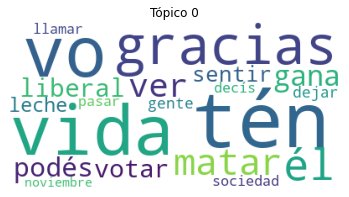

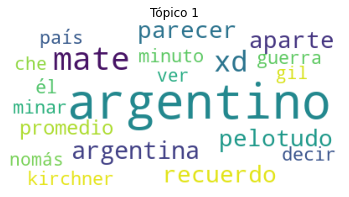

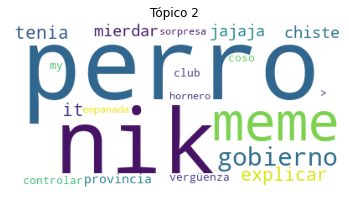

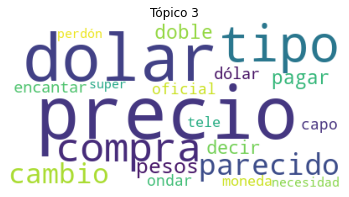

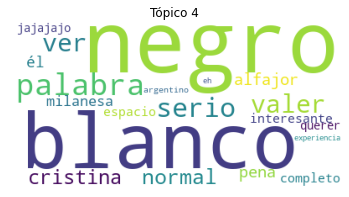

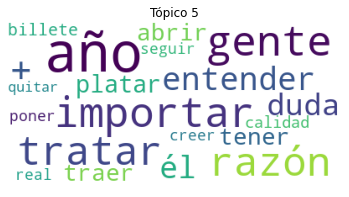

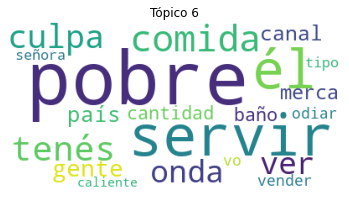

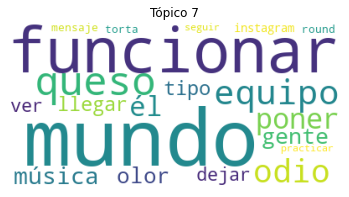

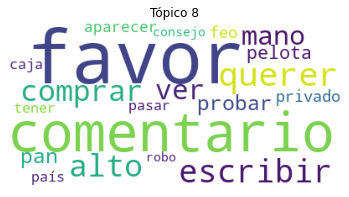

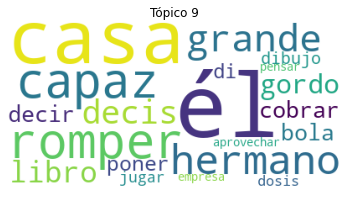

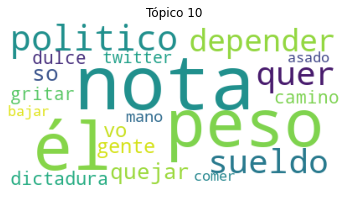

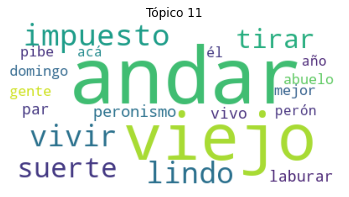

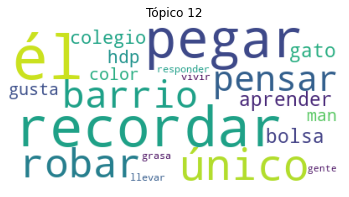

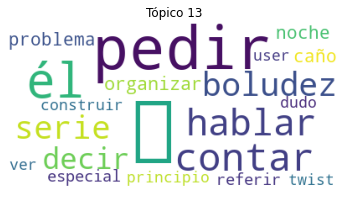

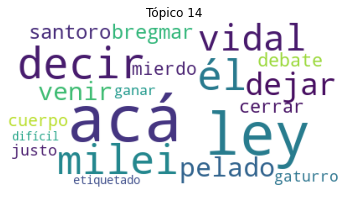

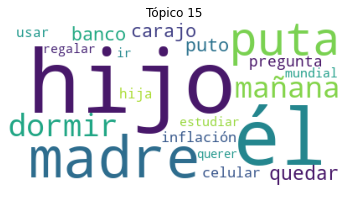

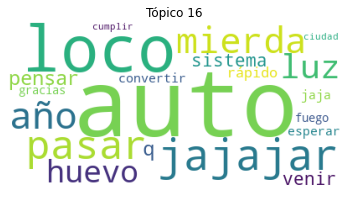

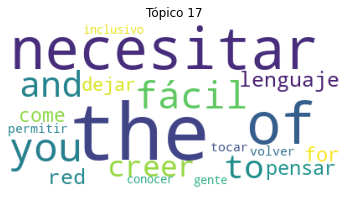

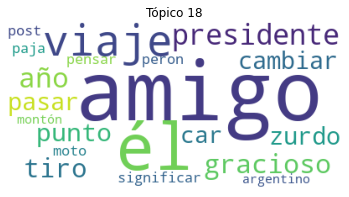

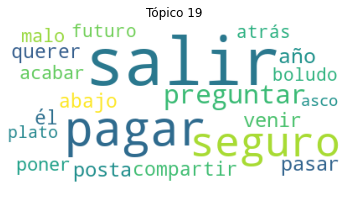

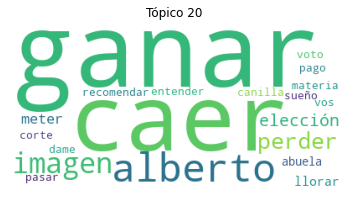

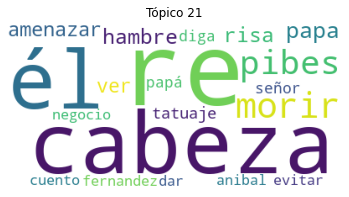

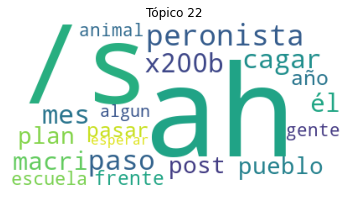

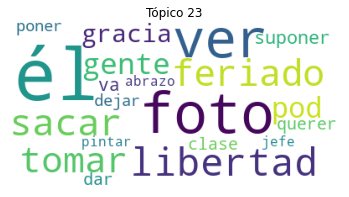

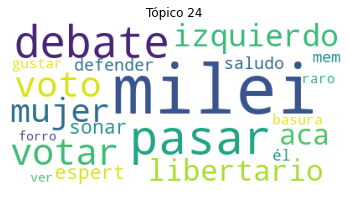

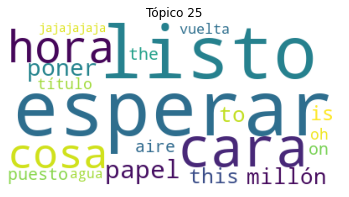

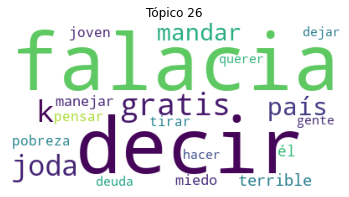

In [8]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(base_model.show_topic(index, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(index))
    plt.show()

In [9]:
reddit = pd.read_csv(TEXT_FILE_READ)

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # old line
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #ent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
                #print(sent_topics_df)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=base_model, corpus=corpus, texts=reddit)

In [10]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,score,id,flair,comms_num,body,comment_parent_id,is_replay,lemma_tokens,body_preprocessing
0,0,12.0,0.2531,"él, recordar, pegar, único, robar, barrio, pen...",1,hgw77qe,Política🏛️,0,"Iba a decir, bue si lo saco de su bolsillo... ...",q9imco,False,"['bue', 'saco', 'bolsillo', 'recorder', 'hdp',...",bue saco bolsillo recorder hdp mantener alcanz...
1,1,2.0,0.2598,"perro, nik, meme, gobierno, explicar, it, teni...",1,hgw7dci,Política🏛️,0,Se volvio un meme el bot del dolar?,hgw666m,True,"['volvio', 'meme', 'dolar']",volvio meme dolar
2,2,26.0,0.3279,"falacia, decir, gratis, k, joda, país, mandar,...",1,hgw69er,Humor:snoo_joy:,0,Este Esteban Lamothe estaba en la ficción de u...,q9i4uj,False,"['ester', 'lamothe', 'ficción', 'villo', 'acá'...",ester lamothe ficción villo acá comedia políti...
3,3,6.0,0.4349,"pobre, servir, él, comida, tenés, culpa, onda,...",1,hgw6zvd,Meme💩,0,Eso porque son todos útos chupa bija.. Venga e...,hgw2528,True,"['úto', 'chupa', 'bijo', 'venir', 'ban', 'nedf...",úto chupa bijo venir ban nedflanducacion
4,4,21.0,0.8089,"re, cabeza, él, morir, pibes, papa, hambre, ri...",1,hgw24ns,Meme💩,0,mas verso burgués que Maximo no hay. Es la rep...,q9hut7,False,"['verso', 'burgués', 'maximo', 'representación']",verso burgués maximo representación
5,5,12.0,0.3722,"él, recordar, pegar, único, robar, barrio, pen...",1,hgw38x8,Meme💩,0,Ayudar con comida? Na mejor unos afiches a tod...,q9hut7,False,"['ayudar', 'comida', 'na', 'afich', 'color']",ayudar comida na afich color
6,6,17.0,0.3461,"the, of, necesitar, you, fácil, and, to, creer...",1,hgw2rml,Meme💩,1,¿Por qué si es un cerdo tiene 6 patas?,q9hut7,False,"['cerdo', 'pata']",cerdo pata
7,7,22.0,0.3515,"ah, /s, peronista, paso, x200b, mes, cagar, él...",1,hgw3wei,Meme💩,0,"Mira, soy tan capitalista que por 15 mil pesos...",q9hut7,False,"['mira', 'capitalisto', 'pesos', 'corrijo', 'c...",mira capitalisto pesos corrijo color
8,8,24.0,0.4082,"milei, pasar, debate, votar, voto, mujer, izqu...",1,hgw78bv,Meme💩,0,Swinetaur libertario de Darkest Perónia. Ruin ...,q9hut7,False,"['swinetaur', 'libertario', 'darkest', 'peróni...",swinetaur libertario darkest perónia ruin come...
9,9,23.0,0.4081,"él, foto, ver, libertad, sacar, feriado, tomar...",1,hgw6rim,Meme💩,0,como no pueden contra elllll. lo ensucian vamo...,q9hut7,False,"['elllll', 'ensuciar', 'milie', 'bastar', 'k']",elllll ensuciar milie bastar k


In [11]:
df_dominant_topic.to_csv(TEXT_SAVE_FILE, index=False)